# MNIST Classification and Neural Network Modelling

## Libraries and Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import idx2numpy
import time

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

## Data Preprocessing

### MNIST Dataset Loading

In [2]:
X_train = './dataset/train-images.idx3-ubyte'
Y_train = './dataset/train-labels.idx1-ubyte'

### Converting IDX binary files to NumPy arrays

In [3]:
X_train = idx2numpy.convert_from_file(X_train)
Y_train = idx2numpy.convert_from_file(Y_train)

### Flattening Images

In [4]:
X_train = X_train.reshape(-1, 28 * 28)

### Data Normalisation

In [5]:
X_train = X_train / 255.0

## Data Preparation

### Dataset Splitting
#### 60% training, 20% validation, and 20% testing

In [6]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.long)
X_temp, X_test, Y_temp, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

### Batching the Data

In [7]:
training_dataset = TensorDataset(X_train, Y_train)
validation_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

def data_loader(batch_size):
    train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = data_loader(64)

## Softmax Regression

### Model Implementation

In [8]:
class SoftmaxRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        return self.linear(x)

### Optimizer and Loss Function Definition

In [9]:
def softmax(learning_rate, weight_decay=0.0):
    model = SoftmaxRegression(input_size=28*28, num_classes=10)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

model, optimizer, criterion = softmax(0.01)

### Training and Logging

In [10]:
def trainer(model, optimizer, criterion, train_loader, val_loader, epochs):
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    training_times = []
    validation_times = []

    for epoch in range(epochs):
        model.train()
        epoch_training_loss = 0
        correct_train = 0
        total_train = 0
        start_training_time = time.time()

        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_training_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        training_time = time.time() - start_training_time
        training_times.append(training_time)
        training_losses.append(epoch_training_loss / len(train_loader))
        training_accuracies.append(correct_train / total_train)

        # Validation Phase
        model.eval()
        epoch_validation_loss = 0
        correct_val = 0
        total_val = 0
        start_validation_time = time.time()

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)

                epoch_validation_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        validation_time = time.time() - start_validation_time
        validation_times.append(validation_time)
        validation_losses.append(epoch_validation_loss / len(val_loader))
        validation_accuracies.append(correct_val / total_val)

    return training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times

training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)

### Testing

In [11]:
def tester(model, test_loader):
    model.eval()

    true_labels = []
    predicted_labels = []

    total = 0
    correct = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.numpy())
            predicted_labels.extend(preds.numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total

    return true_labels, predicted_labels, accuracy

true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

### Visualisation and Plotting

In [12]:
def plotter(training_losses, validation_losses, train_label, val_label):
    plt.plot(training_losses, label=train_label)
    plt.plot(validation_losses, label=val_label)
    plt.legend()
    plt.show()

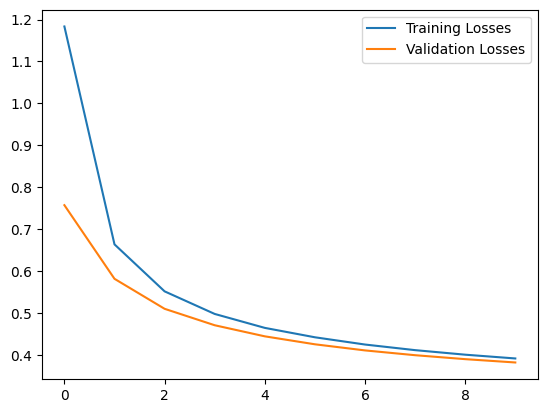

In [13]:
plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

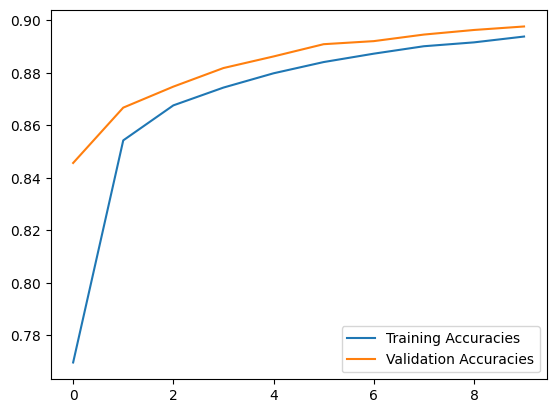

In [14]:
plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

### Performance Analysis

#### Generating a Confusion Matrix

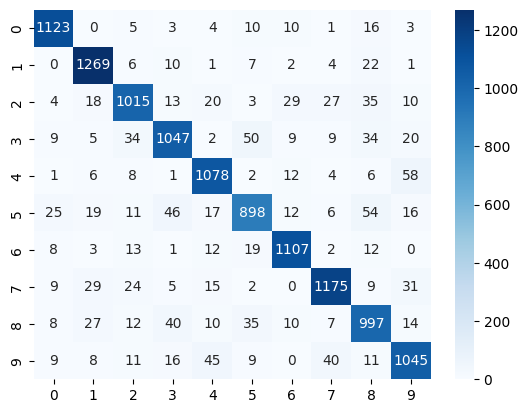

Accuracy 0.8961666666666667


In [15]:
def confusion_matrix_generator(true_labels, predicted_labels):
    confusion = confusion_matrix(true_labels, predicted_labels)
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.show()

confusion_matrix_generator(true_labels, predicted_labels)
print("Accuracy", test_accuracy)

### Parameter Analysis

#### Changing Learning Rates

-------------------- Learning Rate: 0.001 --------------------


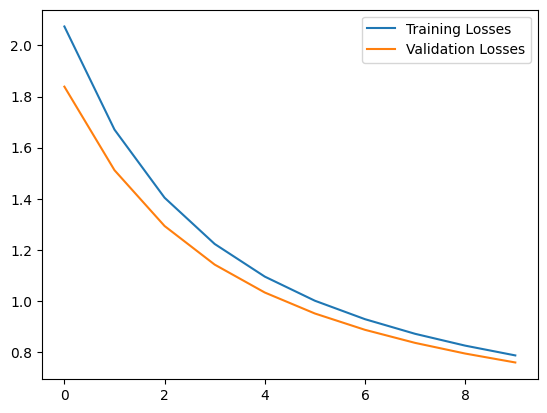

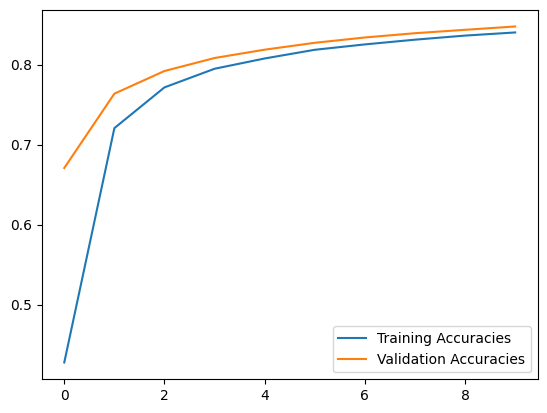

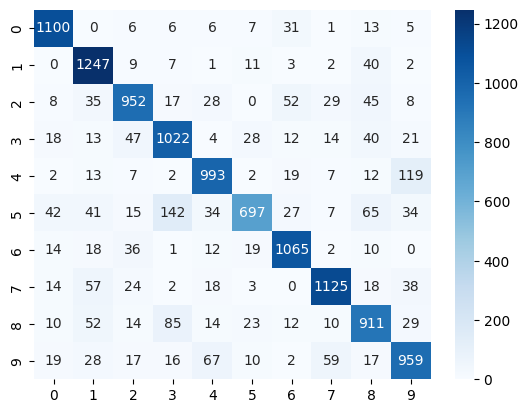

Traning time: 6.495327949523926
Validation time: 1.394733190536499
Test Accuracy 0.83925
-------------------- Learning Rate: 0.01 --------------------


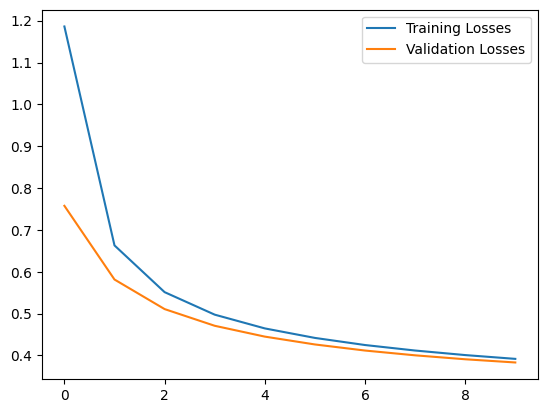

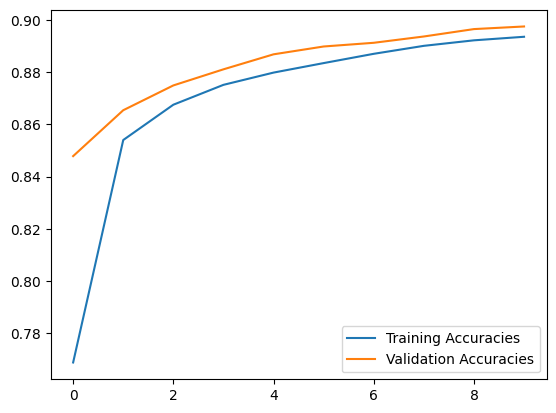

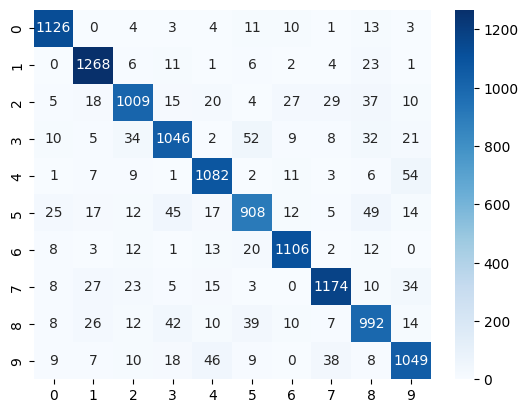

Traning time: 6.496556758880615
Validation time: 1.3081541061401367
Test Accuracy 0.8966666666666666
-------------------- Learning Rate: 0.1 --------------------


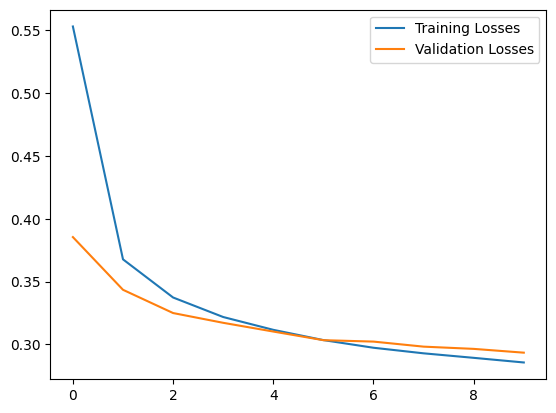

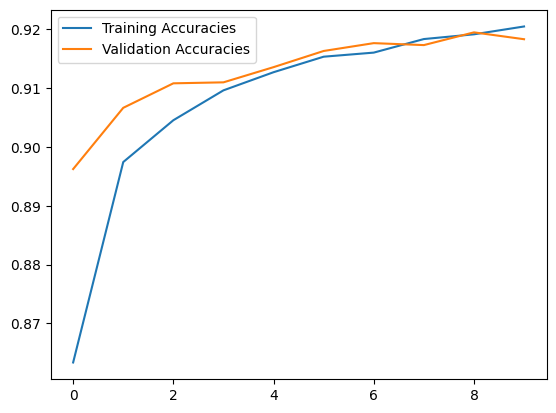

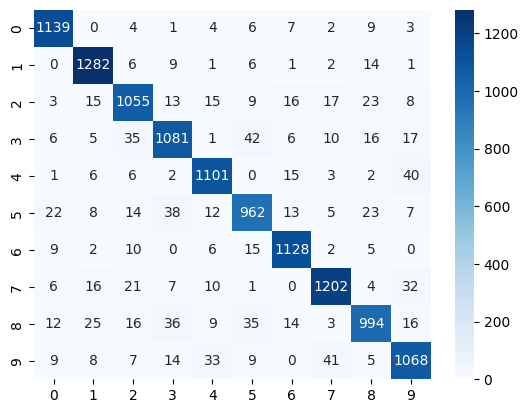

Traning time: 6.0730156898498535
Validation time: 1.2979772090911865
Test Accuracy 0.9176666666666666
-------------------- Learning Rate: 1.0 --------------------


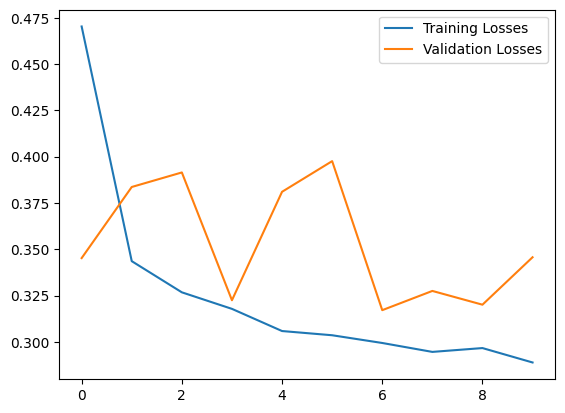

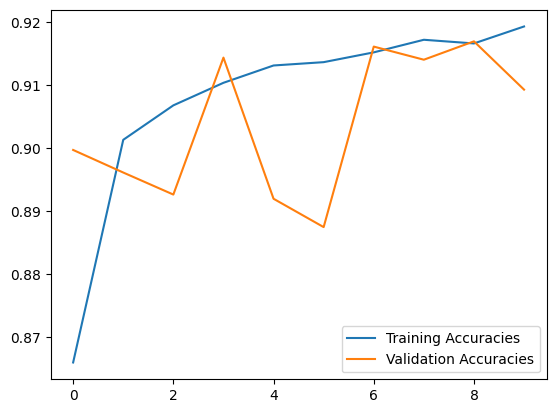

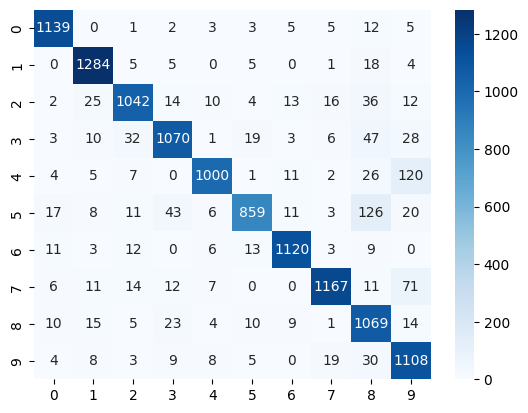

Traning time: 6.359339714050293
Validation time: 1.3396453857421875
Test Accuracy 0.9048333333333334


In [16]:
learning_rates = [0.001, 0.01, 0.1, 1.0]
for lr in learning_rates:
    train_loader, val_loader, test_loader = data_loader(64)
    model, optimizer, criterion = softmax(lr)
    training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
    true_labels, predicted_labels, test_accuracy = tester(model, test_loader)
    print(f"-------------------- Learning Rate: {lr} --------------------")
    plotter(training_losses, validation_losses,  'Training Losses', 'Validation Losses')
    plotter(training_accuracies, validation_accuracies,  'Training Accuracies', 'Validation Accuracies')
    confusion_matrix_generator(true_labels, predicted_labels)
    print("Traning time:", sum(training_times))
    print("Validation time:", sum(validation_times))
    print('Test Accuracy', test_accuracy)

#### Changing Batch Sizes

-------------------- Batch Size: 32 --------------------


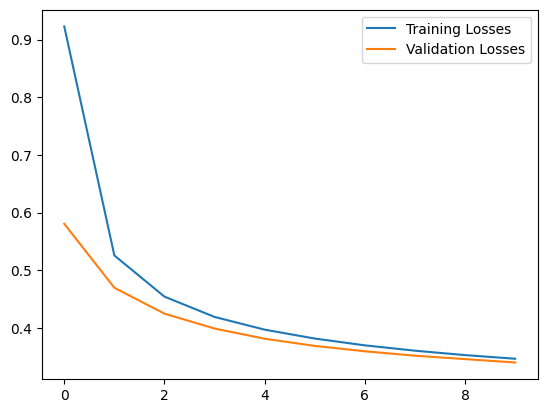

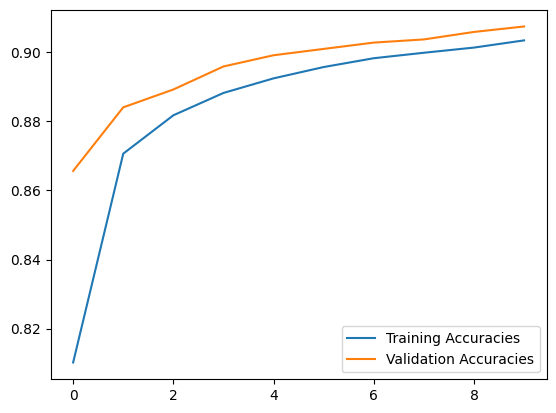

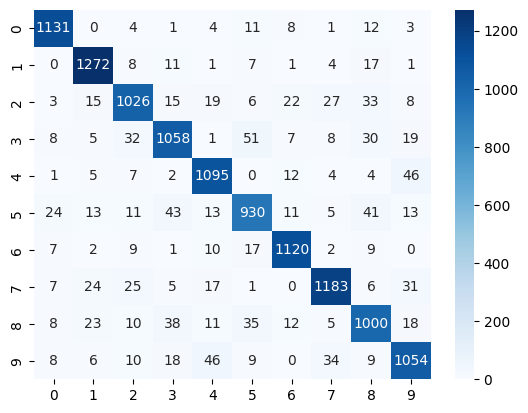

Traning time: 10.471843242645264
Validation time: 1.958571434020996
Test Accuracy 0.90575
-------------------- Batch Size: 64 --------------------


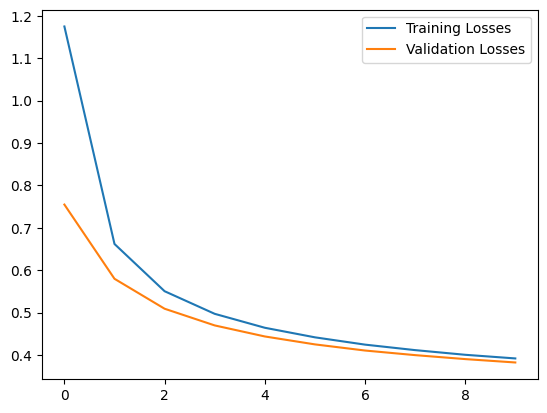

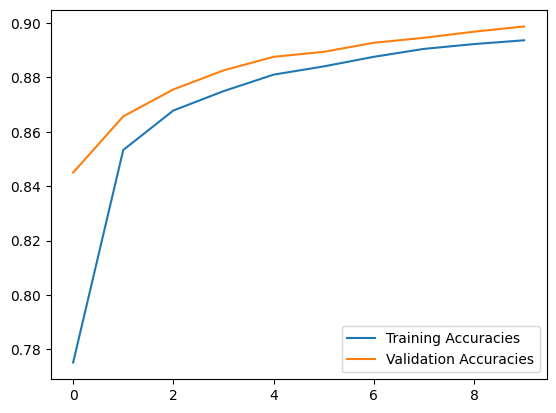

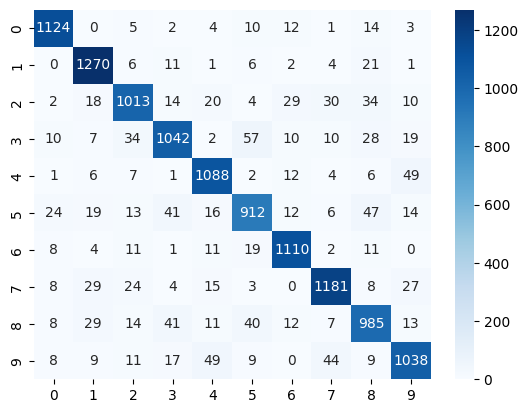

Traning time: 6.100097179412842
Validation time: 1.2622179985046387
Test Accuracy 0.8969166666666667
-------------------- Batch Size: 128 --------------------


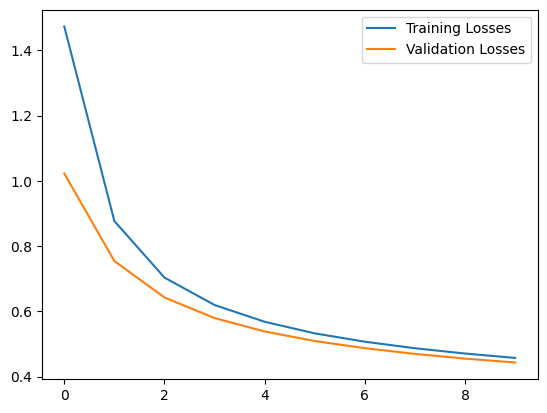

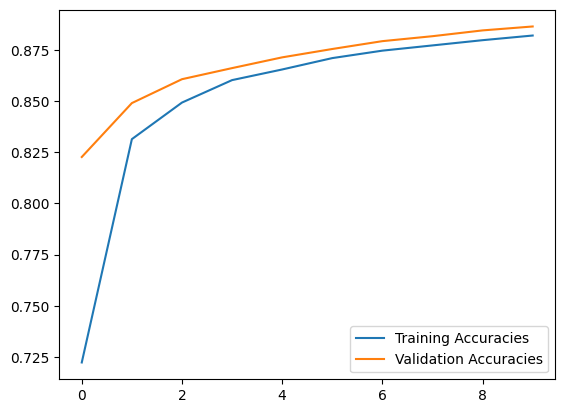

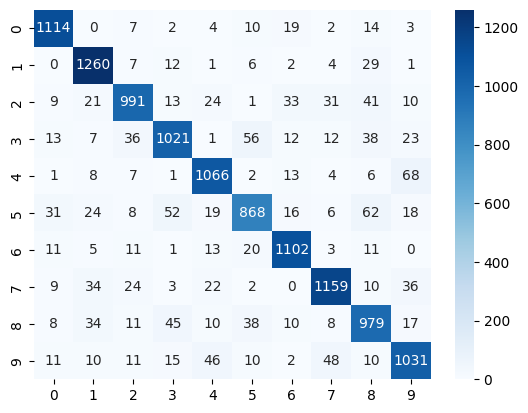

Traning time: 4.4080140590667725
Validation time: 0.9381587505340576
Test Accuracy 0.8825833333333334
-------------------- Batch Size: 256 --------------------


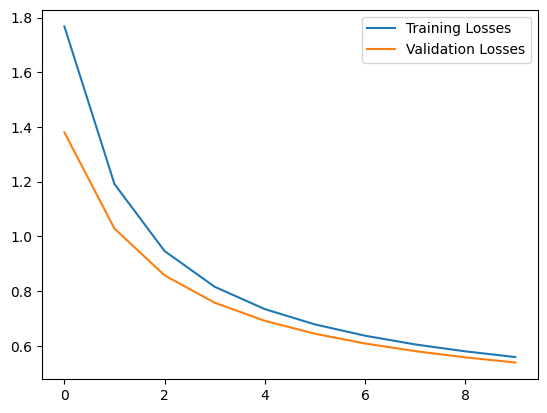

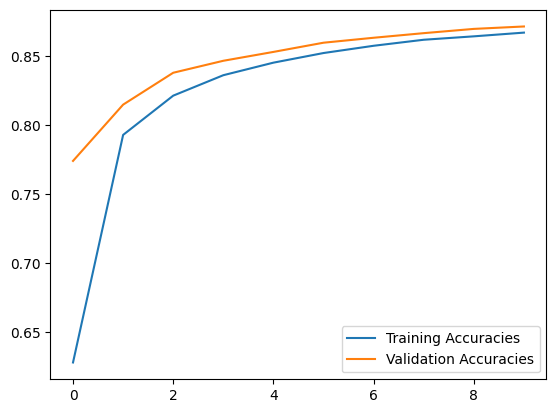

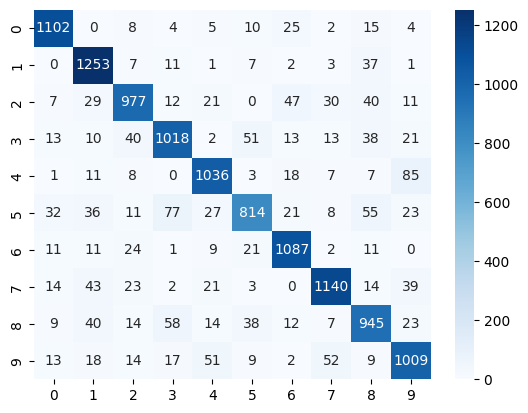

Traning time: 3.120028495788574
Validation time: 0.8438873291015625
Test Accuracy 0.8650833333333333


In [17]:
batch_sizes = [32, 64, 128, 256]
for b in batch_sizes:
    train_loader, val_loader, test_loader = data_loader(b)
    model, optimizer, criterion = softmax(0.01)
    training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
    true_labels, predicted_labels, test_accuracy = tester(model, test_loader)
    print(f"-------------------- Batch Size: {b} --------------------")
    plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')
    plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')
    confusion_matrix_generator(true_labels, predicted_labels)
    print("Traning time:", sum(training_times))
    print("Validation time:", sum(validation_times))
    print('Test Accuracy', test_accuracy)

#### Adding L2 Regularisation

Traning time: 10.372469663619995
Validation time: 1.8773789405822754


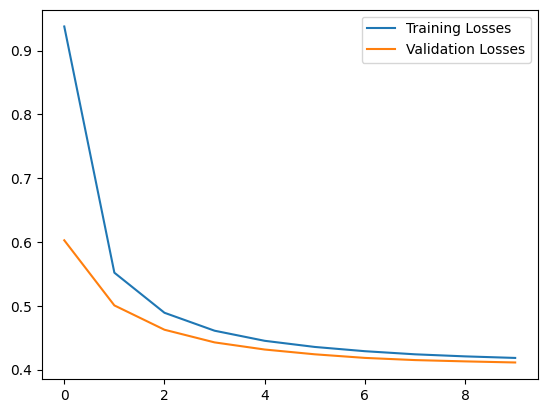

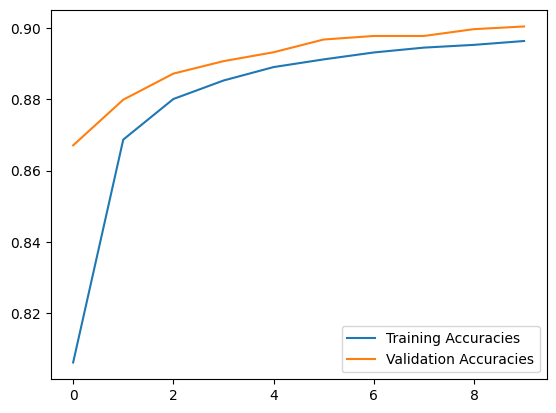

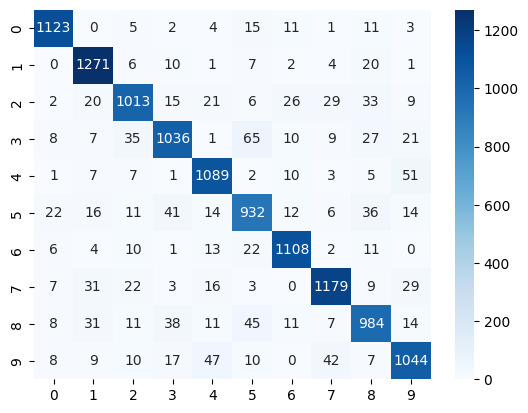

Test Accuracy 0.89825


In [18]:
train_loader, val_loader, test_loader = data_loader(32)

model, optimizer, criterion = softmax(0.01, weight_decay=0.01)

training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)

print("Traning time:", sum(training_times))
print("Validation time:", sum(validation_times))

true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

confusion_matrix_generator(true_labels, predicted_labels)
print("Test Accuracy", test_accuracy)

### Neural Network Modelling

### Model Implementation

In [19]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

### Training and Logging

In [20]:
input_size = X_train.shape[1]
hidden_size = 128
output_size = 10

def neural_network(input_size, hidden_size, output_size, learning_rate, weight_decay=0.0):
    model = FeedforwardNN(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    return model, optimizer, criterion

model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, 0.01)

In [21]:
training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)

print("Traning time:", sum(training_times))
print("Validation time:", sum(validation_times))

true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

Traning time: 30.456560134887695
Validation time: 2.144927978515625


### Visualisation and Plotting

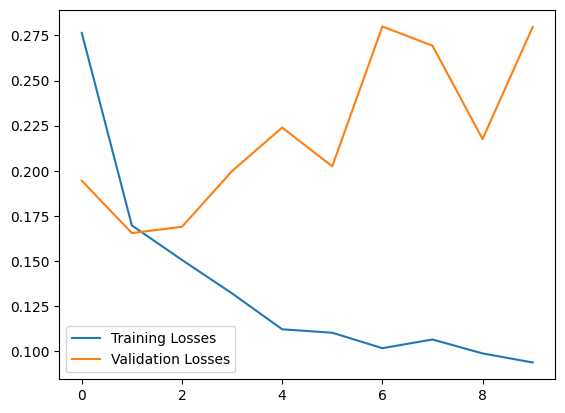

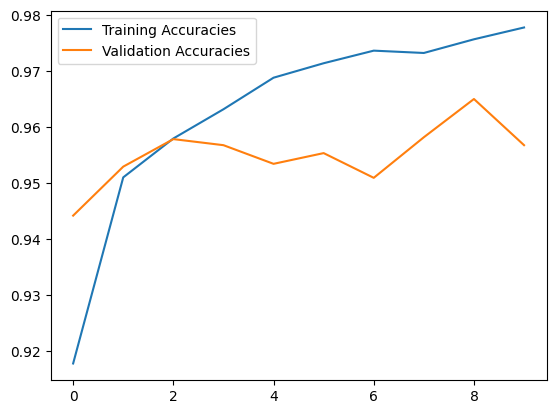

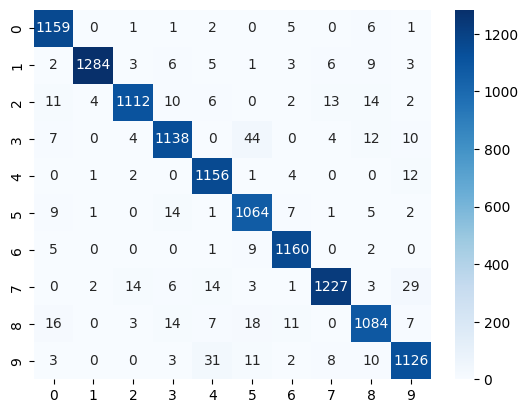

Test Accuracy 0.9591666666666666


In [22]:
plotter(training_losses, validation_losses, 'Training Losses', 'Validation Losses')

plotter(training_accuracies, validation_accuracies, 'Training Accuracies', 'Validation Accuracies')

confusion_matrix_generator(true_labels, predicted_labels)
print("Test Accuracy", test_accuracy)

## Analysis and Comparison

### Metrics for Comparison
1. **Final Test Accuracy**: The percentage of correctly classified images from the test dataset.
2. **Training Time**: The total time taken to train each model across all epochs.

- Best test accuracy using **SoftmaxRegression** was with `batch size = 64` and `learning rate = 0.1`. The **Test Accuracy = 0.9190833333333334**. Training Time: 8.9 sec. Validation Time: 1.87 sec.


- Using **Neural Network** with `batch size = 32` and `learning rate = 0.001`. We reached `Test Accuracy 0.9739166666666667`.  Training Time: 47.41 sec. Validation Time: 3.88 sec.

In [23]:
def softmax_data_generator(batch_sizes, learning_rates):
    softmax_data_no_regularisation = []
    softmax_data_regularisation = []

    for b in batch_sizes:
        for lr in learning_rates:

            # -------------------------- [without L2 regularisation] --------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = softmax(lr)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), test_accuracy]
            softmax_data_no_regularisation.append(temp)

            # ---------------------------- [with L2 regularisation] ----------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = softmax(lr, weight_decay=0.01)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), test_accuracy]
            softmax_data_regularisation.append(temp)

    return softmax_data_no_regularisation, softmax_data_regularisation

In [24]:
def nn_data_generator(input_size, hidden_size, output_size, batch_sizes, learning_rates):
    nn_data_no_regularisation = []
    nn_data_regularisation = []
    for b in batch_sizes:
        for lr in learning_rates:

            # -------------------------- [without L2 regularisation] --------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, lr)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), test_accuracy]
            nn_data_no_regularisation.append(temp)

            # ---------------------------- [with L2 regularisation] ----------------------------

            train_loader, val_loader, test_loader = data_loader(b)
            model, optimizer, criterion = neural_network(input_size, hidden_size, output_size, lr, weight_decay=0.01)
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_times, validation_times = trainer(model, optimizer, criterion, train_loader, val_loader, 10)
            true_labels, predicted_labels, test_accuracy = tester(model, test_loader)

            temp = [sum(training_times), sum(validation_times), test_accuracy]
            nn_data_regularisation.append(temp)
    return nn_data_no_regularisation, nn_data_regularisation

In [25]:
def dataframe_generator(columns, batch_sizes, learning_rates, data_no_regularisation, data_regularisation):
    no_reg_data = [
        [b, lr, "No", *data_no_regularisation[i]]
        for i, (b, lr) in enumerate((b, lr) for b in batch_sizes for lr in learning_rates)
    ]

    reg_data = [
        [b, lr, "Yes", *data_regularisation[i]]
        for i, (b, lr) in enumerate((b, lr) for b in batch_sizes for lr in learning_rates)
    ]

    data = no_reg_data + reg_data
    df = pd.DataFrame(data, columns=columns)

    return df

In [26]:
columns = ["Batch Size", "Learning Rate", "Regularization", "Training Time", "Validation Time", "Test Accuracy"]

batch_sizes = [32, 64, 128, 256]
learning_rates = [0.001, 0.01, 0.1, 1.0]

input_size = X_train.shape[1]
hidden_size = 128
output_size = 10

softmax_data_no_regularisation, softmax_data_regularisation = softmax_data_generator(batch_sizes, learning_rates)
softmax_df = dataframe_generator(columns, batch_sizes, learning_rates, softmax_data_no_regularisation, softmax_data_regularisation)

nn_data_no_regularisation, nn_data_regularisation = nn_data_generator(input_size, hidden_size, output_size, batch_sizes, learning_rates)
nn_df = dataframe_generator(columns, batch_sizes, learning_rates, nn_data_no_regularisation, nn_data_regularisation)


In [27]:
softmax_df

,Batch Size,Learning Rate,Regularization,Training Time,Validation Time,Test Accuracy
0,32,0.001,No,10.618336,1.922368,0.860083
1,32,0.010,No,9.972970,1.838935,0.905667
2,32,0.100,No,9.594610,1.772511,0.921417
3,32,1.000,No,9.496401,1.689946,0.906417
4,64,0.001,No,5.742435,1.251234,0.840083
5,64,0.010,No,5.750075,1.238782,0.895417
6,64,0.100,No,6.178684,1.269684,0.917917
7,64,1.000,No,6.359141,1.321672,0.901000
8,128,0.001,No,4.920842,1.055449,0.815750
9,128,0.010,No,3.910599,0.900768,0.883250


In [28]:
nn_df

,Batch Size,Learning Rate,Regularization,Training Time,Validation Time,Test Accuracy
0,32,0.001,No,22.366846,1.870744,0.969083
1,32,0.010,No,29.285980,2.093653,0.961750
2,32,0.100,No,32.714286,2.087725,0.529250
3,32,1.000,No,37.424560,1.931948,0.098000
4,64,0.001,No,11.753811,1.434222,0.971500
5,64,0.010,No,13.973129,1.448734,0.957583
6,64,0.100,No,18.428567,1.410095,0.718583
7,64,1.000,No,21.892138,1.417789,0.097833
8,128,0.001,No,7.051995,1.087158,0.967917
9,128,0.010,No,7.832273,1.129741,0.969917
